# Covid-19 Detection Using Chest XRay

### Import Libraries

In [128]:
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers import *
from keras.preprocessing.image import ImageDataGenerator
from pathlib import Path
import cv2
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import math
from scipy import signal
from keras.utils import plot_model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint,EarlyStopping

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
trainPath = '/content/drive/MyDrive/dataset/Train'
validationPath = '/content/drive/MyDrive/dataset/Val'

### Data

In [4]:
plt.style.use('seaborn-v0_8')

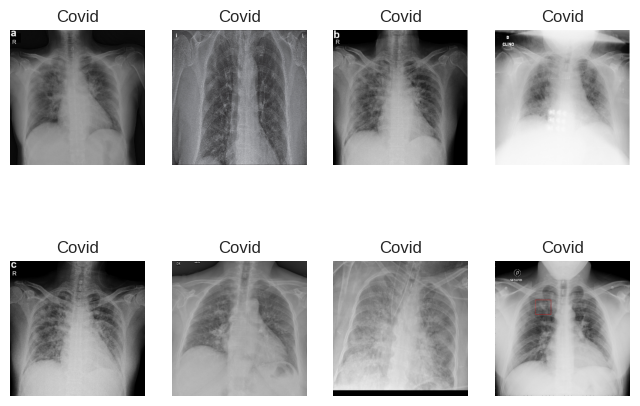

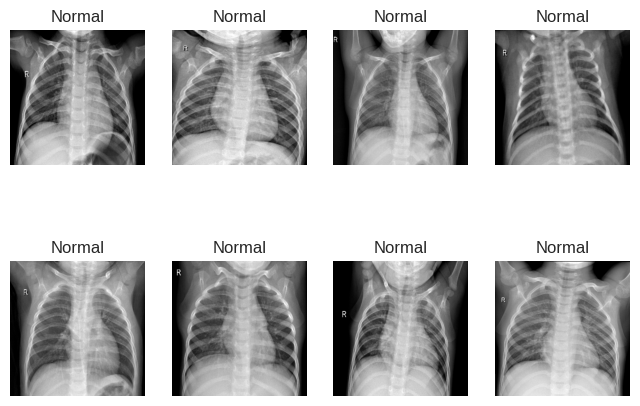

In [5]:
path = Path(trainPath)
dirs = path.glob('*')
for folderDir in dirs:
    label = str(folderDir).split('/')[-1]
    i = 1
    for imgPath in folderDir.glob('*.[jpg][png][jpeg]*'):
        img = cv2.resize(cv2.imread(str(imgPath)),(300,300))
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

        plt.subplot(2,4,i)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')

        if i==8:
            break
        i += 1
    plt.show()

## Applying Gaussian Filtering

In [79]:
def filter(image,sigma=5):
  N = 6*sigma
  t = np.linspace(-3*sigma, 3*sigma, N)
  gau = (1/(math.sqrt(2*math.pi)*sigma))*np.exp(-0.5*(t/sigma)**2)
  kernel = gau[:,np.newaxis]*gau[np.newaxis,:]
  blurred = signal.fftconvolve(image,kernel[:, :, np.newaxis], mode='same')
  blurred = (blurred - blurred.min())/(blurred.max()- blurred.min())*255
  return blurred
def filteredImage(image,sigma1=2,sigma2=3):
  ch2 = filter(image,sigma1)
  ch3 = filter(image,sigma2)
  return np.dstack((image[:,:,0],ch2[:,:,0],ch3[:,:,0]))

In [52]:
img = cv2.imread('/content/drive/MyDrive/dataset/Train/Covid/1-s2.0-S1684118220300682-main.pdf-002-a1.png',cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img,(224,224))

In [56]:
img1 = filteredImage(img,2,4)

In [57]:
img1.shape

(224, 224, 3)

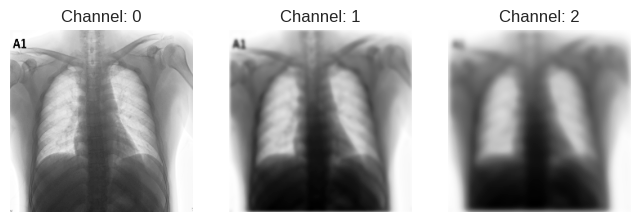

In [69]:
for i in range(3):
  plt.subplot(1,3,i+1)
  plt.imshow(img1[:,:,i])
  plt.axis('off')
  plt.title(f'Channel: {i}')
plt.show()

### Define Augmentation

In [22]:
trainDataGenerator = ImageDataGenerator(
    preprocessing_function = filteredImage,
    rescale = 1.0/255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

validationDataGenerator = ImageDataGenerator(
    preprocessing_function = filteredImage,
    rescale = 1.0/255
)

### Apply Augmentation on Dataset

In [31]:
trainGenerator = trainDataGenerator.flow_from_directory(
    directory = trainPath,
    color_mode='rgb',
    # color_mode='grayscale',
    target_size = (224,224),
    batch_size = 32,
    class_mode = 'binary'
)

validationGenerator = validationDataGenerator.flow_from_directory(
    directory = validationPath,
    color_mode='rgb',
    # color_mode='grayscale',
    target_size = (224,224),
    batch_size = 32,
    class_mode = 'binary'
)

Found 288 images belonging to 2 classes.
Found 60 images belonging to 2 classes.


In [32]:
trainGenerator.class_indices

{'Covid': 0, 'Normal': 1}

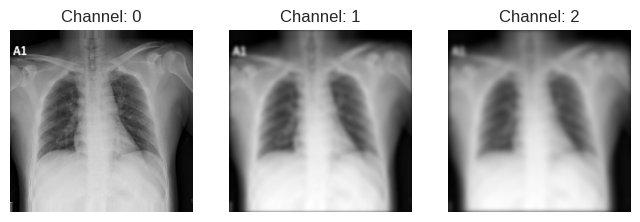

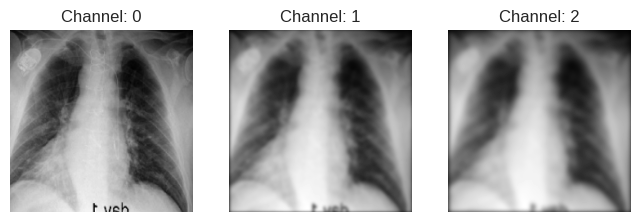

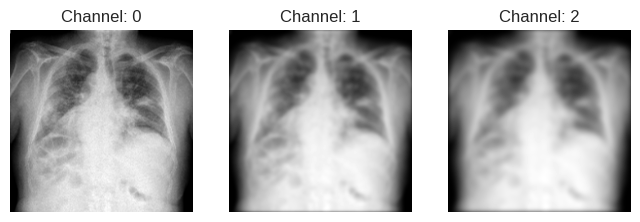

In [68]:
images, labels = next(trainGenerator)

# Plot the first 3 images
for i in range(3):
    for j in range(3):
      plt.subplot(1,3,j+1)
      plt.imshow(images[i][:,:,j], cmap='gray')
      plt.title(f'Channel: {j}')
      plt.axis('off')
    plt.show()

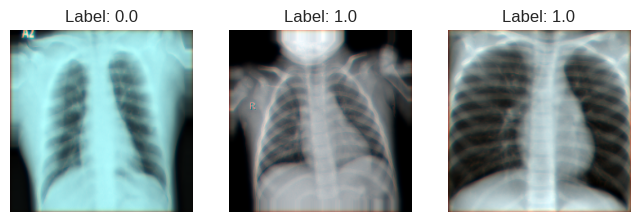

In [67]:
images, labels = next(trainGenerator)

# Plot the first 3 images
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(images[i], cmap='gray')
    plt.title(f'Label: {labels[i]}')
    plt.axis('off')
plt.show()

### Building Custom Model

In [39]:
model = Sequential()
model.add(Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=(224,224,3)))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 conv2d_14 (Conv2D)          (None, 220, 220, 128)     36992     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 110, 110, 128)     0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 110, 110, 128)     0         
                                                                 
 conv2d_15 (Conv2D)          (None, 108, 108, 64)      73792     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 54, 54, 64)        0         
 ng2D)                                                

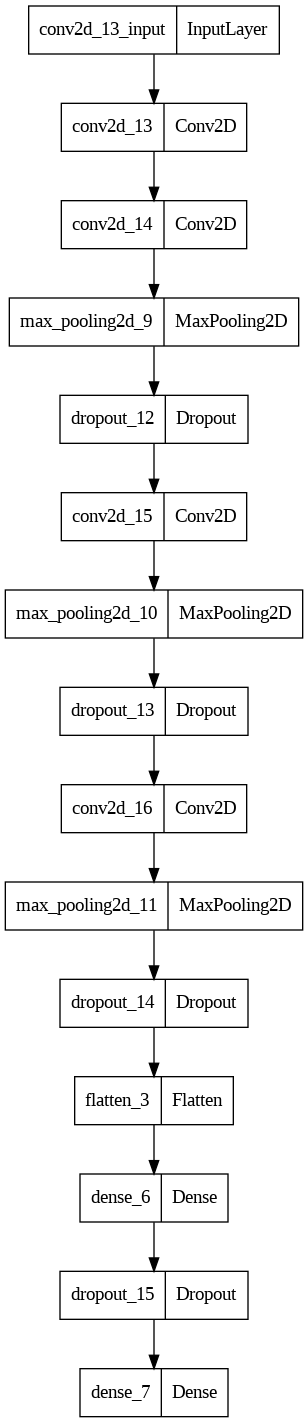

In [70]:
plot_model(model)

### Compile The Model

In [41]:
adam = Adam(learning_rate=0.01)

model.compile(
    optimizer = adam,
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

### Call Back

In [43]:
checkpoint = ModelCheckpoint(
    filepath = 'bestModel.keras',
    monitor = "val_loss",
    save_best_only = True,
    save_weights_only = False,
    mode = "auto",
    save_freq = "epoch"
)
earlystop = EarlyStopping(
    monitor='val_loss',patience=10
)

### Train

In [44]:
hist = model.fit(
    trainGenerator,
    steps_per_epoch = 9,
    epochs = 20,
    validation_data = validationGenerator,
    validation_steps = 2,
    callbacks = [checkpoint,earlystop]
)

Epoch 1/20
9/9 [==============================] - 21s 2s/step - loss: 14.8699 - accuracy: 0.4861 - val_loss: 0.6934 - val_accuracy: 0.5000
Epoch 2/20
9/9 [==============================] - 16s 2s/step - loss: 0.6536 - accuracy: 0.6771 - val_loss: 0.4612 - val_accuracy: 0.9500
Epoch 3/20
9/9 [==============================] - 16s 2s/step - loss: 0.4284 - accuracy: 0.8056 - val_loss: 0.5069 - val_accuracy: 0.9667
Epoch 4/20
9/9 [==============================] - 16s 2s/step - loss: 0.2743 - accuracy: 0.9062 - val_loss: 0.5364 - val_accuracy: 0.9667
Epoch 5/20
9/9 [==============================] - 16s 2s/step - loss: 0.2588 - accuracy: 0.9236 - val_loss: 0.0802 - val_accuracy: 0.9833
Epoch 6/20
9/9 [==============================] - 17s 2s/step - loss: 0.3391 - accuracy: 0.9306 - val_loss: 0.2687 - val_accuracy: 0.9667
Epoch 7/20
9/9 [==============================] - 16s 2s/step - loss: 0.3401 - accuracy: 0.8785 - val_loss: 0.2078 - val_accuracy: 0.9500
Epoch 8/20
9/9 [=================

### Load saved model

In [45]:
from keras.models import load_model

In [125]:
model = load_model('/content/bestModel.keras')

### Accuracy and loss of Train and Validation Data

In [126]:
model.evaluate(trainGenerator)

9/9 [==============================] - 13s 1s/step - loss: 0.1276 - accuracy: 0.9549


[0.1276489943265915, 0.9548611044883728]

In [48]:
model.evaluate(validationGenerator)

2/2 [==============================] - 2s 1s/step - loss: 0.0441 - accuracy: 0.9833


[0.04413299635052681, 0.9833333492279053]

### Plots

In [49]:
history = hist.history
accuracy = history['accuracy']
loss = history['loss']
valAccuracy = history['val_accuracy']
valLoss = history['val_loss']

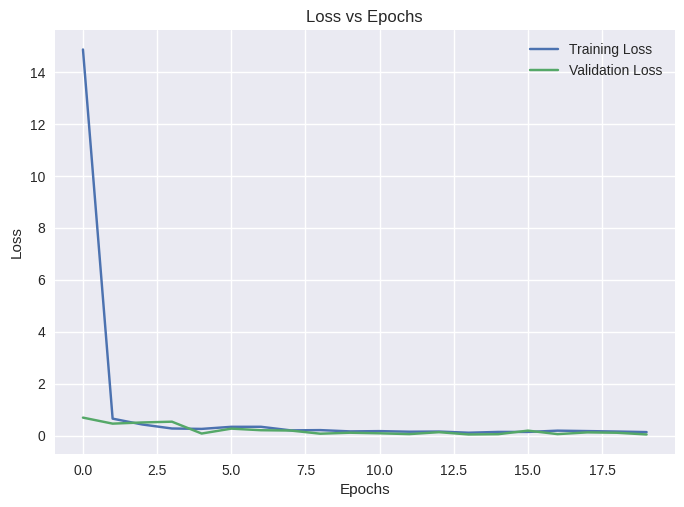

In [50]:
plt.title('Loss vs Epochs')
plt.plot(loss,label='Training Loss')
plt.plot(valLoss,label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

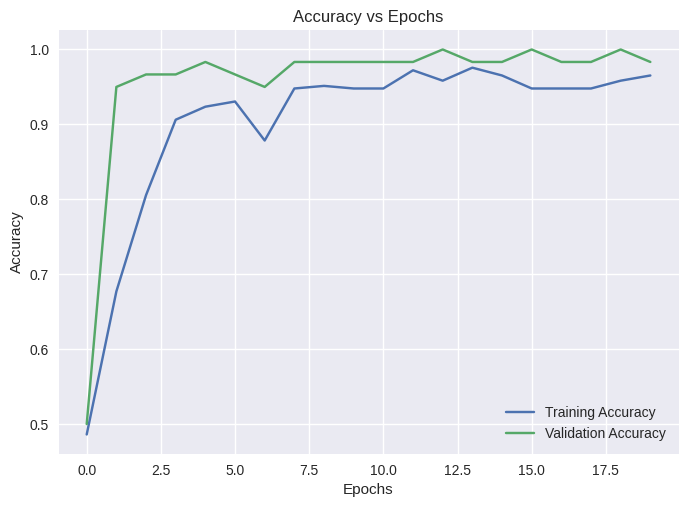

In [51]:
plt.title('Accuracy vs Epochs')
plt.plot(accuracy,label='Training Accuracy')
plt.plot(valAccuracy,label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [122]:
data = validationDataGenerator.flow_from_directory(
    directory = trainPath,
    color_mode='rgb',
    target_size = (224,224),
    batch_size = 32,
    class_mode = 'binary',
    shuffle=False
)

Found 288 images belonging to 2 classes.


9/9 [==============================] - 10s 1s/step


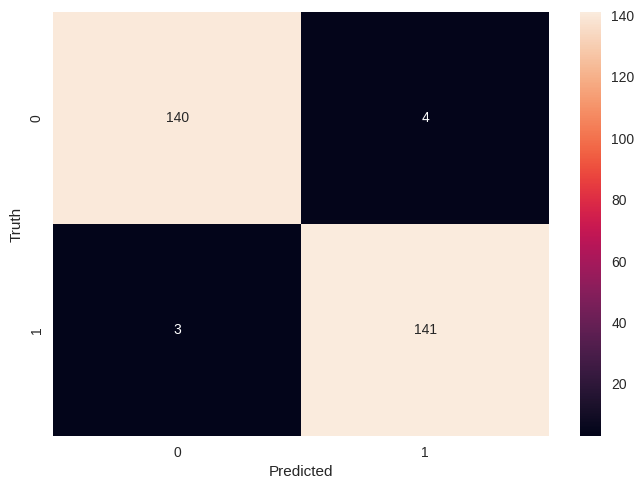

In [127]:
y_true = data.classes

y_pred = model.predict(data)
y_pred = np.where(y_pred > 0.5, 1, 0)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

## Prediction

In [94]:
from keras.preprocessing import image

img = image.load_img('/content/drive/MyDrive/dataset/Prediction/NORMAL2-IM-0352-0001.jpeg', target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = filteredImage(img_array/255.0)

# Expand dimensions to match the shape that the model expects
img_array = np.expand_dims(img_array, axis=0)
predictions = model.predict(img_array)
predicted_class = 'Normal' if predictions[0] > 0.5 else 'Covid'

print(f'The predicted class is: {predicted_class}')


1/1 [==============================] - 0s 19ms/step
The predicted class is: Normal


# Transfer Learning

## VGG16 Model

In [118]:
from keras.applications.vgg16 import VGG16
from keras.models import Model

In [119]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Adding custom top layers
x = base_model.output
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Define the new model
vgg_model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
vgg_model.compile(optimizer=Adam(learning_rate=0.005), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
vgg_hist = vgg_model.fit(
    trainGenerator,
    steps_per_epoch = 9,
    epochs = 20,
    validation_data = validationGenerator,
    validation_steps = 2,
    callbacks = [checkpoint, earlystop]
)


Epoch 1/20
9/9 [==============================] - 18s 2s/step - loss: 2.5773 - accuracy: 0.7153 - val_loss: 0.5497 - val_accuracy: 0.8833
Epoch 2/20
9/9 [==============================] - 19s 2s/step - loss: 0.5189 - accuracy: 0.8889 - val_loss: 0.1529 - val_accuracy: 0.9500
Epoch 3/20
9/9 [==============================] - 17s 2s/step - loss: 0.1208 - accuracy: 0.9479 - val_loss: 0.0043 - val_accuracy: 1.0000
Epoch 4/20
9/9 [==============================] - 15s 2s/step - loss: 0.0952 - accuracy: 0.9653 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 5/20
9/9 [==============================] - 20s 2s/step - loss: 0.0437 - accuracy: 0.9896 - val_loss: 0.0030 - val_accuracy: 1.0000
Epoch 6/20
9/9 [==============================] - 15s 2s/step - loss: 0.0259 - accuracy: 0.9965 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch 7/20
9/9 [==============================] - 15s 2s/step - loss: 0.0325 - accuracy: 0.9931 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch 8/20
9/9 [==================

In [120]:
vgg_history = vgg_hist.history
accuracy = vgg_history['accuracy']
loss = vgg_history['loss']
valAccuracy = vgg_history['val_accuracy']
valLoss = vgg_history['val_loss']

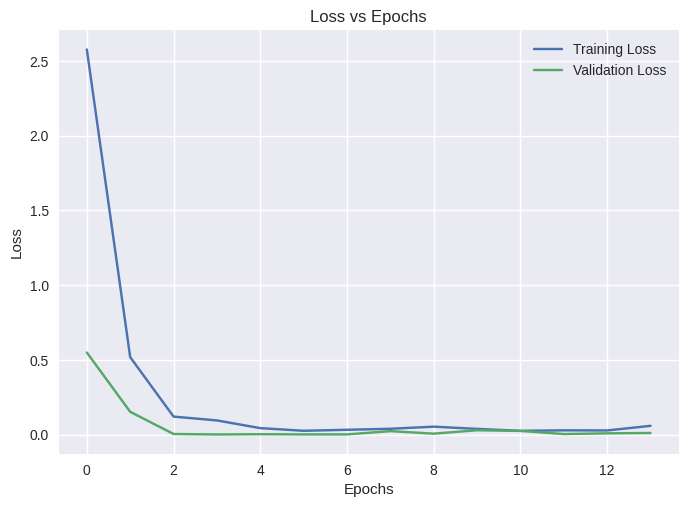

In [121]:
plt.title('Loss vs Epochs')
plt.plot(loss,label='Training Loss')
plt.plot(valLoss,label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

9/9 [==============================] - 10s 1s/step


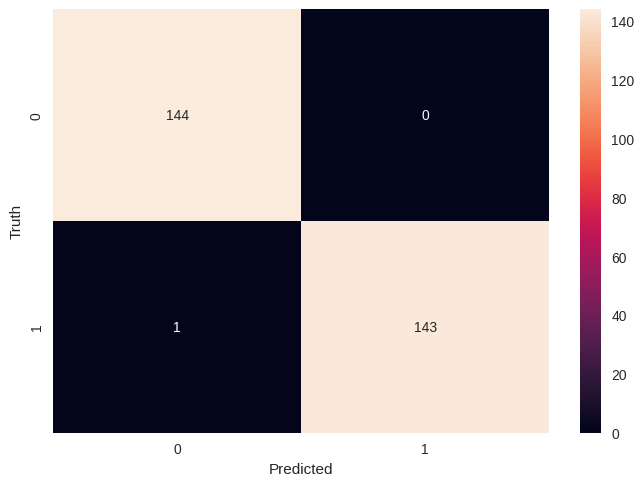

In [124]:
y_true = data.classes

y_pred = vgg_model.predict(data)
y_pred = np.where(y_pred > 0.5, 1, 0)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

## InceptionV3 Model

In [113]:
from keras.applications.inception_v3 import InceptionV3

In [114]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Adding custom top layers
x = base_model.output
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Define the new model
inc_model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
inc_model.compile(optimizer=Adam(learning_rate=0.005), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
inc_hist = inc_model.fit(
    trainGenerator,
    steps_per_epoch = 9,
    epochs = 20,
    validation_data = validationGenerator,
    validation_steps = 2,
    callbacks = [checkpoint, earlystop]
)


87910968/87910968 [==============================] - 0s 0us/step
Epoch 1/20
9/9 [==============================] - 26s 2s/step - loss: 15.5201 - accuracy: 0.7639 - val_loss: 7.0659 - val_accuracy: 0.8667
Epoch 2/20
9/9 [==============================] - 15s 2s/step - loss: 3.8920 - accuracy: 0.9306 - val_loss: 6.0639 - val_accuracy: 0.9500
Epoch 3/20
9/9 [==============================] - 15s 2s/step - loss: 3.7404 - accuracy: 0.9236 - val_loss: 0.7084 - val_accuracy: 0.9667
Epoch 4/20
9/9 [==============================] - 15s 2s/step - loss: 1.7750 - accuracy: 0.9514 - val_loss: 1.7862 - val_accuracy: 0.9667
Epoch 5/20
9/9 [==============================] - 15s 2s/step - loss: 0.3611 - accuracy: 0.9688 - val_loss: 0.2078 - val_accuracy: 0.9667
Epoch 6/20
9/9 [==============================] - 15s 2s/step - loss: 0.0773 - accuracy: 0.9653 - val_loss: 0.0817 - val_accuracy: 0.9500
Epoch 7/20
9/9 [==============================] - 15s 2s/step - loss: 0.1072 - accuracy: 0.9340 - val_loss

In [115]:
inc_history = inc_hist.history
accuracy = inc_history['accuracy']
loss = inc_history['loss']
valAccuracy = inc_history['val_accuracy']
valLoss = inc_history['val_loss']

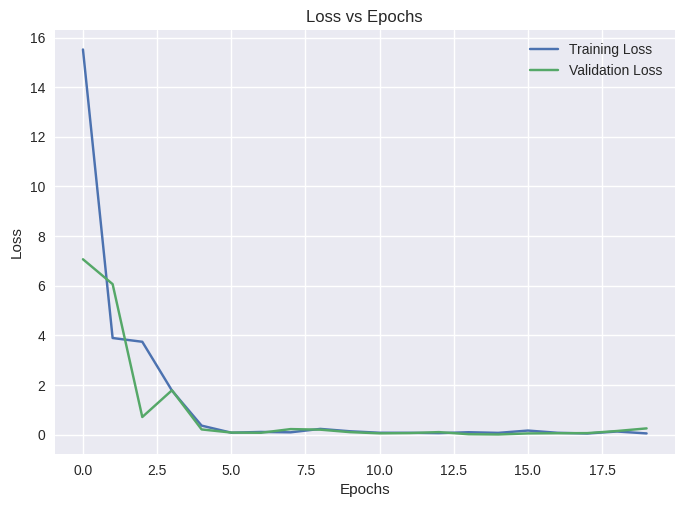

In [116]:
plt.title('Loss vs Epochs')
plt.plot(loss,label='Training Loss')
plt.plot(valLoss,label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

9/9 [==============================] - 11s 1s/step


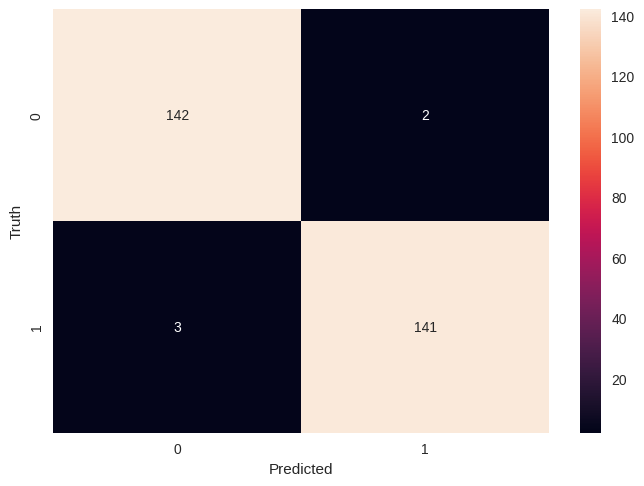

In [117]:
y_true = data.classes

y_pred = inc_model.predict(data)
y_pred = np.where(y_pred > 0.5, 1, 0)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()